# MLflow tracker demo

This demo demonstrates how to seamlessly integrate and transfer logs from MLflow to MLRun, </br>
creating a unified and powerful platform for your machine learning experiments.

You can combine MLflow and MLRun for a comprehensive solution for managing, tracking, and deploying machine learning models. 

This notebook guides you through the process of:

1. Setting up the integration between MLflow and MLRun.
2. Extracting data, metrics, and artifacts from MLflow experiments.
3. Creating MLRun artifacts and projects to organize and manage the transferred data.
4. Leveraging MLRun's capabilities for model deployment and data processing.

By the end of this demo, you will have a understanding of how to establish a smooth flow of data between MLflow and MLRun.

## MLRun installation and configuration
Before running this notebook make sure the mlrun package is installed (pip install mlrun) and that you have configured the access to MLRun service.

In [1]:
# Install MLRun and scikit-learn if not already installed. Run this only once. Restart the notebook after the install!
# %pip install mlrun scikit-learn~=1.3.0

Then you can import the necessary packages.

In [2]:
import pandas as pd
import os
import mlrun
from mlrun.datastore.targets import ParquetTarget
import mlrun.feature_store as fstore

Create a project for this demo:

In [3]:
# Create a project for this demo:
project = mlrun.get_or_create_project(name="mlflow-tracking-example", context="./")

> 2024-03-27 15:34:40,940 [info] Project loaded successfully: {'project_name': 'mlflow-tracking-example-guy'}


Set all the necessary environment variables for the Databricks cluster:

In [4]:
DATABRICKS_HOST="add your host"
DATABRICKS_TOKEN="add your token"
DATABRICKS_CLUSTER_ID="add your cluster id"

In [5]:
os.environ["DATABRICKS_HOST"] = DATABRICKS_HOST
os.environ["DATABRICKS_TOKEN"] = DATABRICKS_TOKEN


In [6]:
# Set the Databricks environment variables
job_env = {
    "DATABRICKS_HOST": DATABRICKS_HOST,
    "DATABRICKS_CLUSTER_ID": DATABRICKS_CLUSTER_ID
}
secrets = {"DATABRICKS_TOKEN": DATABRICKS_TOKEN}

# Set the secrets in the project
project.set_secrets(secrets)

## Create a feature set and ingest data

This is a short example of how to create a feature set about music preferences.

In [7]:
# create df
columns = ["id", "name", "age", "gender", "favorite_music_type"]
data = [
    (1, "Alice", 20, "f", "Pop"),
    (2, "Bob", 30, "m", "Rock"),
    (3, "Charlie", 25, "m", "Pop"),
    (4, "David", 40, "m", "Classical"),
    (5, "Eva", 18, "f", "Pop"),
    (6, "Frank", 32, "m", "Rock"),
    (7, "Grace", 28, "f", "Pop"),
    (8, "Henry", 45, "m", "Classical"),
    (9, "Ivy", 22, "f", "Pop"),
    (10, "Jack", 38, "m", "Classical"),
    (11, "Karen", 27, "f", "Pop"),
    (12, "Liam", 19, "m", "Pop"),
    (13, "Mia", 27, "f", "Rock"),
    (14, "Nora", 31, "f", "Rock"),
    (15, "Oliver", 29, "m", "Pop"),
    (16, "Ben", 38, "m", "Pop"),
    (17, "Alicia", 20, "f", "Pop"),
    (18, "Bobby", 30, "m", "Rock"),
    (19, "Charlien", 22, "f", "Pop"),
    (20, "Davide", 40, "m", "Classical"),
    (21, "Evans", 19, "m", "Pop"),
    (22, "Franklin", 34, "m", "Rock"),
    (23, "Grace", 22, "f", "Pop"),
    (24, "Henrik", 48, "m", "Classical"),
    (25, "eevee", 29, "f", "Pop"),
    (26, "Jack", 75, "m", "Classical"),
    (27, "Karen", 26, "f", "Pop"),
    (28, "Lian", 21, "f", "Pop"),
    (29, "kia", 27, "f", "Rock"),
    (30, "Novak", 30, "m", "Rock"),
    (31, "Olivia", 29, "f", "Pop"),
    (32, "Benjamin", 18, "m", "Pop")
]
df = pd.DataFrame(data, columns=columns)

Transfer the data to DataBricks.

In [8]:
# Where to save the data in DataBricks
target_path = f"dbfs:///demos/mlrun_databricks_demo/music.parquet"
output_path = f"dbfs:///demos/mlrun_databricks_demo/music_output_new.parquet"

targets = [ParquetTarget(path=target_path)]

# Create a feature set and ingest the data
fset = fstore.FeatureSet(name="music_fset", entities=[fstore.Entity("name")])
fstore.ingest(fset, df, targets=targets, overwrite=True)

# Get the target path and check it
dbfs_data_path = fset.get_target_path()
dbfs_data_path

'dbfs:///demos/mlrun_databricks_demo/1711553684480_33/music.parquet'

We can look and see how how our data is logged in the DataBricks cluster:
(only top 20 rows)

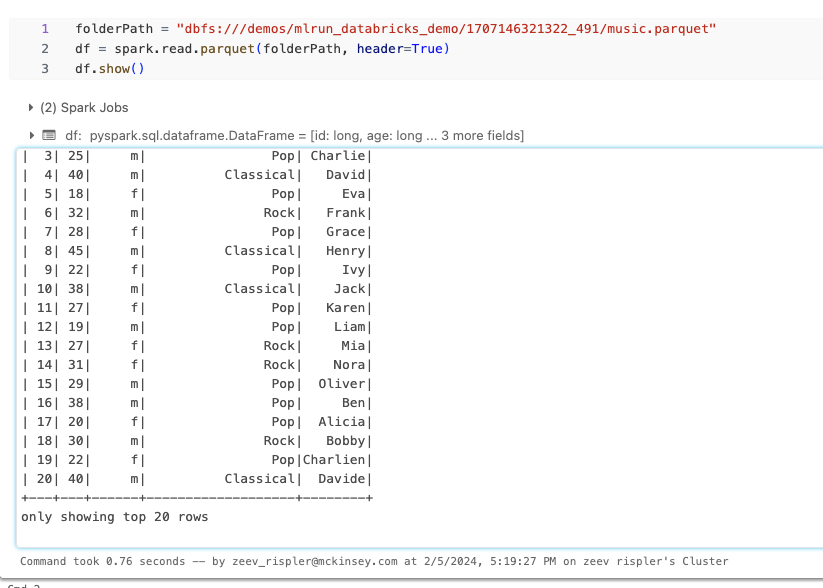

## Create a data processing function

The following code demonstrates how to create a simple data processing function using MLRun.</br>
The function will process the data and show some statistics.</br>


In [ ]:
%%writefile process_data.py


#  Here is an example of Spark processing.
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, min, max
import pandas as pd
import json
import fsspec

def process_data(data_path: str, data_output_path: str):
    spark = SparkSession.builder.appName("MusicDemo").getOrCreate()
    spark_df = spark.read.parquet(data_path, header=True)
    spark_df = spark_df.drop("name", "id")
    
    music_stats = spark_df.groupBy("favorite_music_type").agg(
        avg("age").alias("avg_age"),
        min("age").alias("min_age"),
        max("age").alias("max_age")
    )
    music_stats.show()
    pandas_df = spark_df.toPandas()
    pandas_df.to_parquet(data_output_path)
    # spark_df.write.mode("overwrite").parquet(data_output_path)

    return {"music_data": data_output_path}

In [9]:
process_data_function = project.set_function(
    func="./zeev-demos/mlflow-databricks/process_data.py",
    name="process-data",
    kind="databricks",
    image="mlrun/mlrun",
)
                                

Set all parameters necessary for the function and run it.

In [10]:
for name, val in job_env.items():
    process_data_function.spec.env.append({"name": name, "value": val})
params = {
    "task_parameters": {"timeout_minutes": 15},
    "data_path": dbfs_data_path,
    "data_output_path": output_path.replace("dbfs://", "/dbfs"),
}
run = process_data_function.run(
    handler="process_data",
    params=params,
)

> 2024-03-27 15:34:45,422 [info] Storing function: {'name': 'process-data-process-data', 'uid': 'a9c770f8377046bda3061e61a5c015c2', 'db': 'http://mlrun-api:8080'}
> 2024-03-27 15:34:45,675 [info] Job is running in the background, pod: process-data-process-data-89bhh
> 2024-03-27 15:34:49,272 [info] Running with an existing cluster: {'cluster_id': '0327-134616-43m7kfxk'}
> 2024-03-27 15:34:49,492 [info] Starting to poll: 493449112310004
> 2024-03-27 15:34:49,539 [info] Workflow intermediate status: mlrun_task__15_34_48_703046: RunLifeCycleState.PENDING
> 2024-03-27 15:34:50,947 [info] Workflow intermediate status: mlrun_task__15_34_48_703046: RunLifeCycleState.PENDING
> 2024-03-27 15:34:53,063 [info] Workflow intermediate status: mlrun_task__15_34_48_703046: RunLifeCycleState.RUNNING
> 2024-03-27 15:34:56,737 [info] Workflow intermediate status: mlrun_task__15_34_48_703046: RunLifeCycleState.RUNNING
> 2024-03-27 15:35:00,947 [info] Artifacts found. Run name: mlrun_task__15_34_48_703046


> 2024-03-27 15:35:07,910 [info] Run execution finished: {'status': 'completed', 'name': 'process-data-process-data'}


## Create an MLflow Xgboost function

The following code demonstrates how to create a simple Xgboost model using MLflow and log the results.</br>
MLflow will log the model, parameters, metrics, and artifacts, and MLRun will track the run and collect the data.

In [11]:
%%writefile training.py

import mlflow
import mlflow.xgboost
import xgboost as xgb
from mlflow import log_metric
from sklearn import datasets
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import pandas as pd

def example_xgb_run(df: str):
    df = pd.read_parquet(df)
    
    df = df.replace(["f", "m"], [0, 1])
    df = df.replace(["Pop", "Rock", "Classical"], [0, 1, 2])
    
    # Prepare, train, and test data
    y = df.pop('favorite_music_type')
    X = df

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Enable auto logging
    mlflow.xgboost.autolog()

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    with mlflow.start_run():
        # Train model
        params = {
            "objective": "multi:softprob",
            "num_class": 3,
            "learning_rate": 0.3,
            "eval_metric": "mlogloss",
            "colsample_bytree": 1.0,
            "subsample": 1.0,
            "seed": 42,
        }
        model = xgb.train(params, dtrain, evals=[(dtrain, "train")])
        
        # Evaluate model
        y_proba = model.predict(dtest)
        y_pred = y_proba.argmax(axis=1)
        loss = log_loss(y_test, y_proba)
        acc = accuracy_score(y_test, y_pred)
        
        # Log metrics by hand
        mlflow.log_metrics({"log_loss": loss, "accuracy": acc})

Overwriting training.py


## Log the data from MLflow in MLRun 

### Change the MLRun configuration to use the tracker


In [12]:
import mlrun

mlrun.mlconf.external_platform_tracking.enabled = True

These are the three options to run tracking:
- Set: `mlrun.mlconf.external_platform_tracking.mlflow.match_experiment_to_runtime` to True. This determines the run id and is the safest method
- Set the experiment name at: `mlflow.environment_variables.MLFLOW_EXPERIMENT_NAME.set`. This determines the experiment mlrun will track and find the run added to it.
- Just run it, mlrun will look across all experiments and search for added run, this is not recomended.

### Create the mlrun function

In [13]:
# Use the first run option from above
mlrun.mlconf.external_platform_tracking.mlflow.match_experiment_to_runtime = True

# Create a MLRun function using the example train file (all the functions must be located in it):
training_func = project.set_function(
    func="training.py",
    name="example-xgb-run",
    kind="job",
    image="mlrun/mlrun",
)

### Run the function

Run the function using MLRun. This will log the data from MLflow in MLRun.</br>
After running the function, you can look at the UI and see that all metrics and parameters are logged in MLRun.

In [14]:
import mlrun.feature_store as fstore

feature_set = fstore.get_feature_set("music_fset", "mlflow-tracking-example")

In [26]:
df = feature_set.to_dataframe()
df = df.drop(['id'], axis=1)

In [27]:
# df = project.list_().to_objects()[0].to_dataitem().as_df()
df_path = "./music.parquet"
df.to_parquet(df_path)


In [28]:
# Run the example code using mlrun
train_run = training_func.run(
    local=True,
    handler="example_xgb_run",
    inputs={"df": df_path},
)

> 2024-03-27 15:37:22,829 [info] Storing function: {'name': 'example-xgb-run-example-xgb-run', 'uid': '6ff324dd21d64b6290d45a001957dda2', 'db': 'http://mlrun-api:8080'}
> 2024-03-27 15:37:22,912 [warning] `mlconf.external_platform_tracking.mlflow.match_experiment_to_runtime` is set to True but the MLFlow experiment name environment variable ('MLFLOW_EXPERIMENT_NAME') is set for using the name: 'example-xgb-run-example-xgb-run'. This name will be overriden with MLRun's runtime name as set in the MLRun configuration: 'example-xgb-run-example-xgb-run'.
[0]	train-mlogloss:0.82467
[1]	train-mlogloss:0.64706
[2]	train-mlogloss:0.52480
[3]	train-mlogloss:0.43768
[4]	train-mlogloss:0.37410
[5]	train-mlogloss:0.32686
[6]	train-mlogloss:0.29057
[7]	train-mlogloss:0.26192
[8]	train-mlogloss:0.23885
[9]	train-mlogloss:0.22004


2024/03/27 15:37:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/03/27 15:37:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/User/.pythonlibs/mlrun-base/lib/python3.

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mlflow-tracking-example-guy,...1957dda2,0,Mar 27 15:37:22,completed,example-xgb-run-example-xgb-run,v3io_user=zeevrkind=localowner=zeevrhost=jupyter-zeevr-9f4ffb7bb-8c4mfmlflow-user=iguaziomlflow-run-name=stately-cow-437mlflow-run-id=f66d6149d54c4958a2485c941d86a538mlflow-experiment-id=608717337209571124,df,colsample_bytree=1.0custom_metric=Noneearly_stopping_rounds=Noneeval_metric=mloglosslearning_rate=0.3maximize=Nonenum_boost_round=10num_class=3objective=multi:softprobseed=42subsample=1.0verbose_eval=True,accuracy=0.7142857142857143log_loss=0.9622776094122579train-mlogloss=0.2200447738170624,feature_importance_weight_jsonfeature_importance_weight_pngmodel


> 2024-03-27 15:37:31,415 [info] Run execution finished: {'status': 'completed', 'name': 'example-xgb-run-example-xgb-run'}


### Examine the results

You can examine the results using the UI or by looking at the outputs of the run.</br>
The outputs include the model, the metrics, and the artifacts, and are completely independent of MLflow.

In [29]:
train_run.outputs

{'accuracy': 0.7142857142857143,
 'log_loss': 0.9622776094122579,
 'train-mlogloss': 0.2200447738170624,
 'feature_importance_weight_json': 'store://artifacts/mlflow-tracking-example-guy/example-xgb-run-example-xgb-run_feature_importance_weight_json@6ff324dd21d64b6290d45a001957dda2',
 'feature_importance_weight_png': 'store://artifacts/mlflow-tracking-example-guy/example-xgb-run-example-xgb-run_feature_importance_weight_png@6ff324dd21d64b6290d45a001957dda2',
 'model': 'store://artifacts/mlflow-tracking-example-guy/example-xgb-run-example-xgb-run_model@6ff324dd21d64b6290d45a001957dda2'}

In [30]:
train_run.status.results

{'accuracy': 0.7142857142857143,
 'log_loss': 0.9622776094122579,
 'train-mlogloss': 0.2200447738170624}

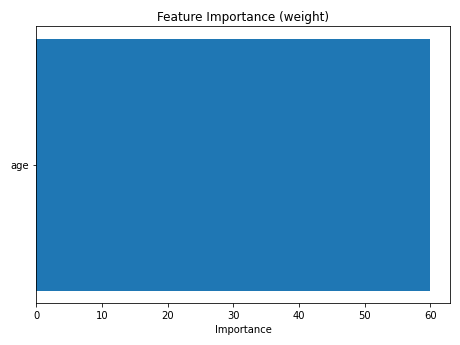

In [31]:
train_run.artifact("feature_importance_weight_png").show()

### You can also examine the results using the UI

Look at collected artifacts: 

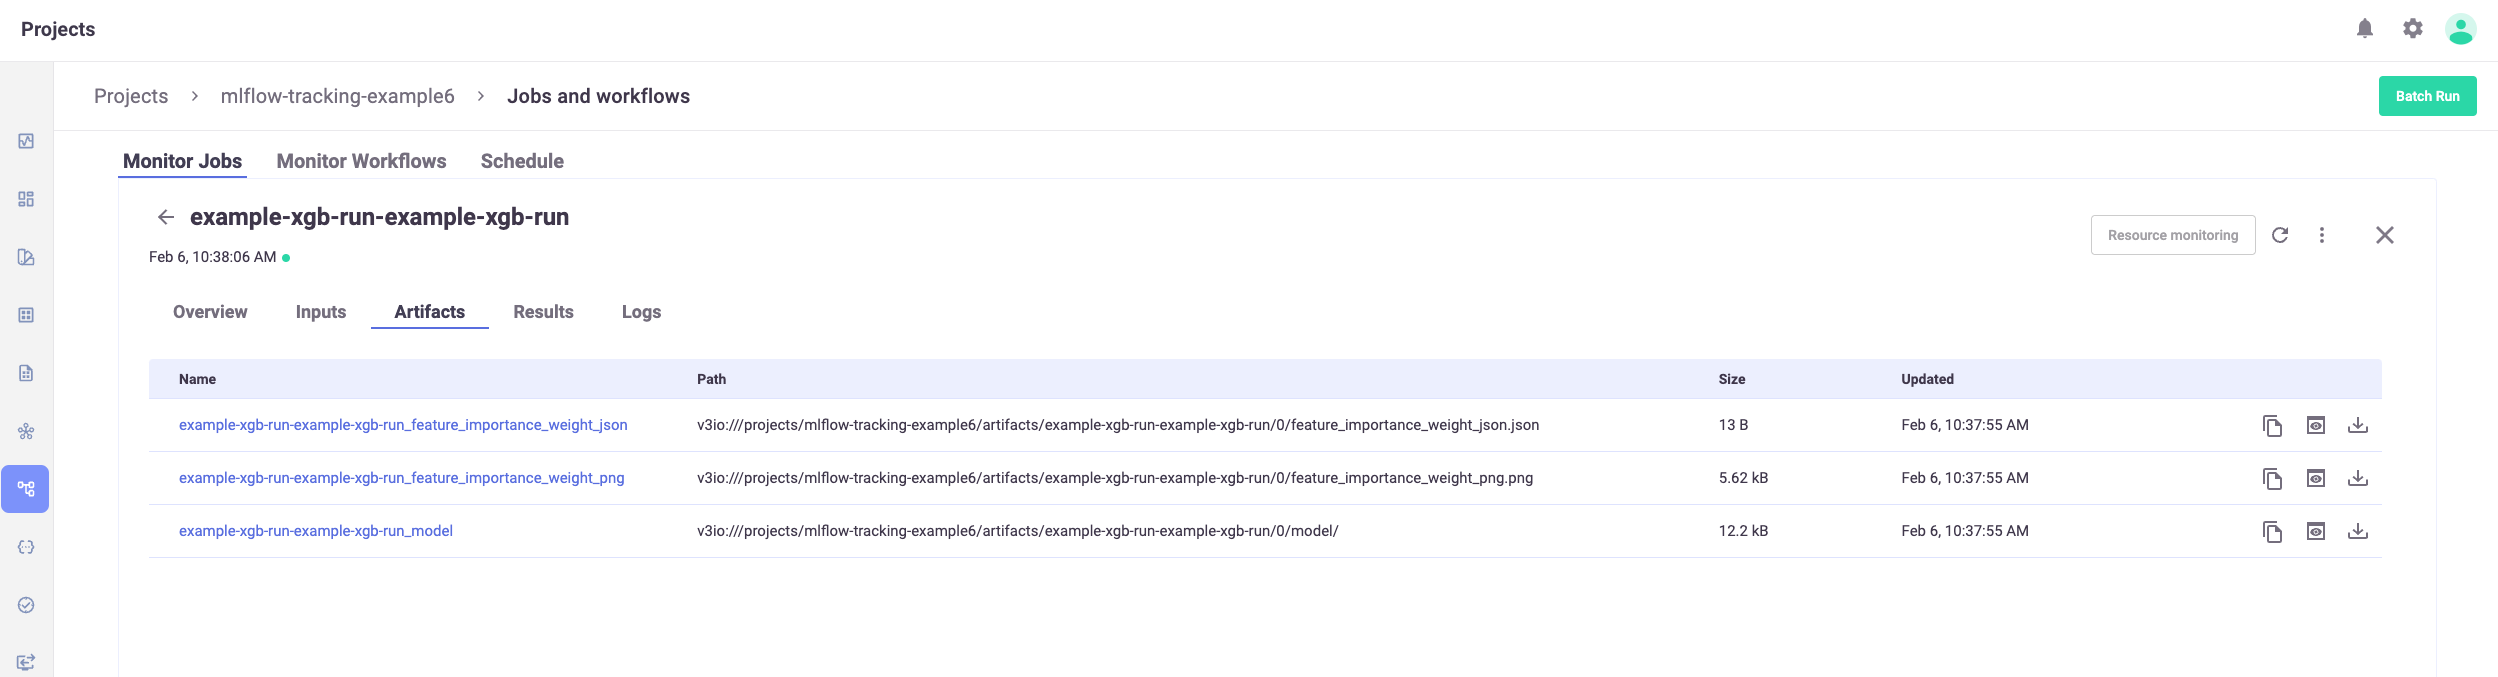

And at results:

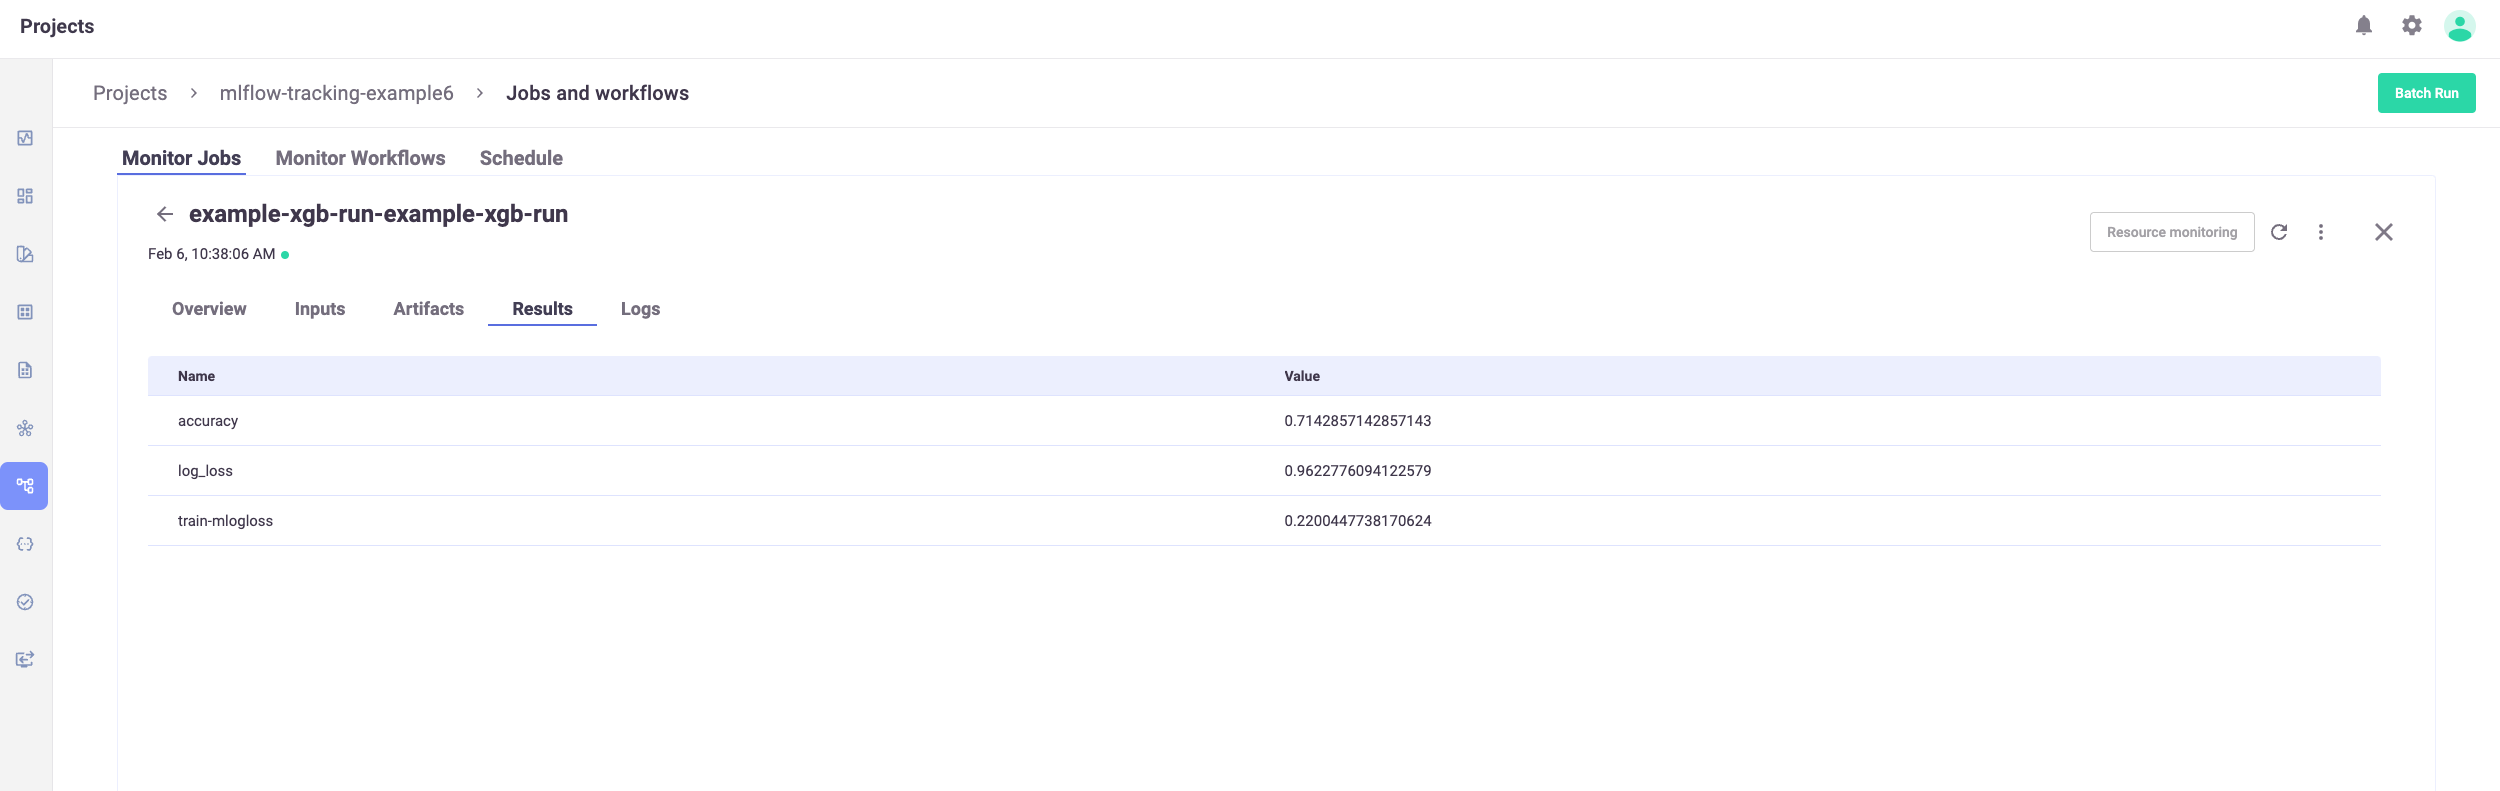

## Use the function for model serving

### Create the server and serving function

Create a serving function that uses the model from the previous run and serves it using MLRun.</br>
We will create a mock server to test the model in a local environment.

In [33]:
serving_func = project.set_function(
    func="function.yaml",
    name="example-xgb-server",
)

In [34]:
# Add the model
serving_func.add_model(
    "mlflow_xgb_model",
    class_name="MLFlowModelServer",
    model_path=train_run.outputs["model"],
)

In [35]:
# Create a mock server
server = serving_func.to_mock_server()

> 2024-03-27 15:37:31,627 [info] model mlflow_xgb_model was loaded
> 2024-03-27 15:37:31,628 [info] Loaded ['mlflow_xgb_model']


### Test the model 

In [36]:
# An example taken randomly  
result = server.test("/v2/models/mlflow_xgb_model/predict", {"inputs":[{"age": 20, "gender": 0}]})

In [37]:
# Look at the result, it shows the probability of the given example to be each of the 
# irises featured in the dataset
result

{'id': '43a61d06f2694fa695bdd6561b487131',
 'model_name': 'mlflow_xgb_model',
 'outputs': [[0.9242361187934875, 0.0418272465467453, 0.033936627209186554]]}

We predicted that a 20 year old female would like pop!